In [1]:
import numpy as np
import pandas as pd
import argparse
from glob import glob
from os import path

from sympy.solvers import solve
from sympy import Symbol
import scipy.stats as sstats

from utils import SimulateData
from stopsignalmetrics import SSRTmodel

In [2]:
def get_args():
    parser = argparse.ArgumentParser(description='simulation visualization')
    parser.add_argument('--sim_dir',
                        default='./simulated_data',
                        help='location of simulated data')
    parser.add_argument('--out_dir',
                        default='./ssrt_metrics',
                        help='location to save SSRT metrics')
    parser.add_argument('--ssrt_model',
                        default='all')
    args = parser.parse_args([])
    return(args)

def generate_exgauss_sampler_from_fit(data,
                                      default_sample_size=100000):
    FIT_K, FIT_LOC, FIT_SCALE = sstats.exponnorm.fit(data)
    FIT_LAMBDA = 1/(FIT_K*FIT_SCALE)
    FIT_BETA = 1/FIT_LAMBDA

    def sample_exgauss(sample_size=default_sample_size,
                       beta=FIT_BETA, scale=FIT_SCALE, loc=FIT_LOC):
        exp_out = np.random.exponential(scale=beta, size=sample_size)
        norm_out = np.random.normal(scale=scale, size=sample_size)
        return (exp_out+norm_out) + loc

    return sample_exgauss

In [3]:
# GET ABCD INFO
abcd_data = pd.read_csv('abcd_data/minimal_abcd_no_issue_3.csv')

SSDs = abcd_data.SSDDur.unique()
SSDs = [i for i in SSDs if i == i]
SSDs.sort()
acc_per_SSD = pd.DataFrame()
for ssd in SSDs:
    curr_means = abcd_data.query(
        "SSDDur == %s and correct_stop==0.0" % ssd
    ).groupby('NARGUID').mean()['choice_accuracy']
    curr_means.name = ssd
    acc_per_SSD = pd.concat([acc_per_SSD, curr_means], 1, sort=True)

go_accs = abcd_data.query(
        "trial_type == 'GoTrial' and correct_go_response in ['1.0', '0.0']"
    ).groupby('NARGUID').mean()['choice_accuracy']
go_accs.name = -1
acc_per_SSD = pd.concat([acc_per_SSD, go_accs], 1, sort=True)

p = Symbol('p')
guess_mean = acc_per_SSD.mean()[0.0]
go_mean = acc_per_SSD.mean()[-1]
p_guess_per_SSD = []
for ssd in acc_per_SSD.columns:
    curr_mean = acc_per_SSD.mean()[ssd]
    solution = solve(p*guess_mean + (1-p)*go_mean - curr_mean, p)
    assert len(solution) == 1
    p_guess_per_SSD.append(solution[0])

SSD0_RTs = abcd_data.query(
    "SSDDur == 0.0 and correct_stop==0.0"
    ).stop_rt_adjusted.values
sample_exgauss = generate_exgauss_sampler_from_fit(SSD0_RTs)

In [4]:
SSD_guesss_dict = {ssd: p_guess for ssd, p_guess in zip(SSDs, p_guess_per_SSD)}
SSD_guesss_dict

{0.0: 1.00000000000000,
 50.0: 0.841267812256568,
 100.0: 0.604685133548690,
 150.0: 0.450800885199760,
 200.0: 0.291362614587630,
 250.0: 0.205845982758886,
 300.0: 0.147778040621424,
 350.0: 0.0857490996232271,
 400.0: 0.0658960847076383,
 450.0: 0.0370359052900360,
 500.0: 0.0303846371645836,
 550.0: 0.00860486486964472,
 600.0: 0.0158515184440697,
 650.0: 0.00352448737501439,
 700.0: 0.0824908338534645,
 750.0: 0.0421190813493337,
 800.0: 0.193990235544082,
 850.0: 0.169073810362365,
 900.0: 0.247408778393641}

In [16]:
def add_guess_RTs_and_sort(goRTs, SSD):
    
    curr_n = len(goRTs)
    
    p_guess = SSD_guesss_dict[SSD]

    if p_guess == 1.0:
        total_n = 10000
    else:
        total_n = int(np.floor(curr_n * (1/(1-p_guess))))

    
    guess_RTs = sample_exgauss(total_n-curr_n)
    if p_guess == 1.0:
        guess_RTs.sort()
        return guess_RTs
    else:
        all_RTs = np.concatenate([goRTs, guess_RTs])
        all_RTs.sort()
        return all_RTs
    
def simulate_graded_RTs_and_sort(n_trials, SSD):
    params = simulator._init_params({})
    params['n_trials'] = n_trials
    
    params['mu_go'] = simulator._log_mu_go(params['mu_go'], SSD)
    simulator._set_n_guesses_per_type(params)
    
    data_dict = simulator._simulate_go_trials(simulator._init_data_dict(), params)
    goRTs = data_dict['RT']
    goRTs.sort()
    return goRTs

def get_nth_RT(P_respond, goRTs):
    """Get nth RT based P(response|signal) and sorted go RTs."""
    nth_index = int(np.rint(P_respond*len(goRTs))) - 1
    if nth_index < 0:
        nth_RT = goRTs[0]
    elif nth_index >= len(goRTs):
        nth_RT = goRTs[-1]
    else:
        nth_RT = goRTs[nth_index]
    return nth_RT


def SSRT_wReplacement( metrics, sorted_go_RTs):
    P_respond = metrics['p_respond']
    corrected_P_respond = P_respond/(1-metrics['omission_rate'])
    goRTs_w_replacements = np.concatenate((
        sorted_go_RTs,
        [metrics['max_RT']] * metrics['omission_count']))
    
    nrt = get_nth_RT(P_respond, goRTs_w_replacements)

    return nrt - metrics['mean_SSD']

In [6]:
simulator = SimulateData()
ssrtmodel = SSRTmodel()

In [7]:
data = simulator.simulate()

In [8]:
data

,condition,SSD,trial_idx,mu_go,mu_stop,accum_go,accum_stop,process_go,process_stop,block,goRT,stopRT
0,stop,0.0,0,0.2,0.6,22.426278,100.260354,"[0, 0.11356183333034321, 0.16135447197380168, ...","[3.741797492804561, 4.759702596186653, 7.59727...",0,NaN,NaN
1,stop,0.0,1,0.2,0.6,24.631715,101.586549,"[0, 0.03725951700511218, 0.8106337088423684, 0...","[6.538750052757905, 7.411523515565964, 4.70835...",0,NaN,NaN
2,stop,0.0,2,0.2,0.6,34.944274,100.221311,"[0.5065205298306699, 0, 0.46534272746183714, 1...","[2.0414623505753378, 3.3594917132342323, 3.010...",0,NaN,NaN
3,stop,0.0,3,0.2,0.6,35.632330,102.957195,"[0.15678305570908685, 2.336683323267962, 1.881...","[0, 0, 2.5372215065497263, 2.5905161057761488,...",0,NaN,NaN
4,stop,0.0,4,0.2,0.6,37.216809,101.831087,"[0.8132961112849872, 0, 0, 2.511997142581279, ...","[0, 0, 0, 0.5968973257334408, 0, 1.94613741453...",0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
12995,go,NaN,995,0.2,0.6,100.172062,0.000000,"[1.1466724783832771, 1.4655468959489963, 2.893...",[],0,497.0,NaN
12996,go,NaN,996,0.2,0.6,101.743635,0.000000,"[0, 0, 0.6836906599783805, 0.2534774346915013,...",[],0,786.0,NaN
12997,go,NaN,997,0.2,0.6,103.332533,0.000000,"[0, 1.709510216084986, 1.3264368108715132, 1.0...",[],0,475.0,NaN
12998,go,NaN,998,0.2,0.6,102.072366,0.000000,"[0, 0, 1.419424926293508, 1.5879244657921363, ...",[],0,631.0,NaN


In [18]:
info = []
sub_id = 1
goRTs = data.loc[data.goRT.notnull(), 'goRT'].values
for SSD in np.arange(0,600,50):
    curr_df = data.query("condition=='go' | condition=='stop' and SSD == %s" % SSD).copy()
    curr_metrics = ssrtmodel.fit_transform(curr_df)
    
    goRTs_w_guesses = add_guess_RTs_and_sort(goRTs, SSD)
    SSRT_w_guesses = SSRT_wReplacement(curr_metrics, goRTs_w_guesses)
    
    goRTs_graded = simulate_graded_RTs_and_sort(1000, SSD)
    
    SSRT_w_graded = SSRT_wReplacement(curr_metrics, goRTs_graded)
    info.append([
        sub_id,
        SSD,
        curr_metrics['SSRT'],
        SSRT_w_guesses,
        SSRT_w_graded
    ])
    


In [20]:
out_df = pd.DataFrame(info, columns=['ID', 'SSD', 'SSRT_standard', 'SSRT_w_guesses', 'SSRT_w_graded'])

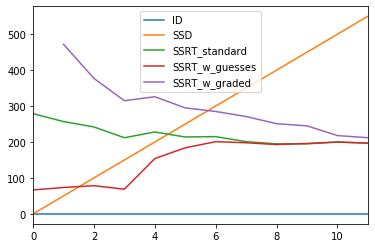

In [22]:
_ = out_df.plot()